# Data preprocess

## Create GIE

In [741]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import kmapper as km
import pyballmapper as pbm
import statistics
import seaborn as sb

In [743]:
data = pd.read_csv("Highest level of qual_nomis_2025_02_23_161034.csv")

In [745]:
data

,2022 ward,LAD Code,Total: All usual residents aged 16 years and over,No qualifications,Level 1 and entry level qualifications,Level 2 qualifications,Apprenticeship,Level 3 qualifications,Level 4 qualifications or above,Other qualifications
0,Astley Bridge,E05000650,100,17.5,10.3,15.3,6.2,17.9,30.7,2.1
1,Bradshaw,E05000651,100,16.9,9.8,12.7,7.7,17.9,32.5,2.6
2,Breightmet,E05000652,100,25.9,11.8,15.2,7.8,16.3,20.2,2.8
3,Bromley Cross,E05000653,100,12.1,8.2,13.4,6.5,18.1,39.8,1.9
4,Crompton (Bolton),E05000654,100,27.4,11.5,13.9,4.7,15.2,24.1,3.1
...,...,...,...,...,...,...,...,...,...,...
367,Tyldesley (Wigan),E05000860,100,18.8,11.0,15.4,6.5,18.4,27.3,2.5
368,Wigan Central,E05000861,100,18.8,9.2,13.5,6.4,15.5,34.1,2.6
369,Wigan West,E05000862,100,21.1,10.7,16.3,7.6,17.8,24.4,2.1
370,Winstanley (Wigan),E05000863,100,15.0,9.6,15.3,7.7,19.9,30.3,2.2


In [747]:
# set education levels colums
education_levels = [
    "No qualifications", 
    "Level 1 and entry level qualifications", 
    "Level 2 qualifications", 
    "Apprenticeship", 
    "Level 3 qualifications", 
    "Level 4 qualifications or above"
]

# set years of schooling based on the general schooling years for each level
years_of_schooling = {
    "No qualifications": 0,
    "Level 1 and entry level qualifications": 5,
    "Level 2 qualifications": 10,
    "Apprenticeship": 12,
    "Level 3 qualifications": 13,
    "Level 4 qualifications or above": 16
}

# create a df 
df_edu = data[["LAD Code"] + education_levels + ["Total: All usual residents aged 16 years and over"]].copy()

# convert numeric columns to float
df_edu[education_levels] = df_edu[education_levels].replace(',', '', regex=True).apply(pd.to_numeric, errors='coerce')
df_edu["Total: All usual residents aged 16 years and over"] = df_edu["Total: All usual residents aged 16 years and over"].replace(',', '', regex=True).apply(pd.to_numeric, errors='coerce')

# compute the ratio for each education level
df_edu[education_levels] = df_edu[education_levels].div(df_edu["Total: All usual residents aged 16 years and over"], axis=0)

# compute avarage schooling years
df_edu["Avg Schooling Years"] = sum(df_edu[level] * years_of_schooling[level] for level in education_levels)

df_edu

,LAD Code,No qualifications,Level 1 and entry level qualifications,Level 2 qualifications,Apprenticeship,Level 3 qualifications,Level 4 qualifications or above,Total: All usual residents aged 16 years and over,Avg Schooling Years
0,E05000650,0.175,0.103,0.153,0.062,0.179,0.307,100,10.028
1,E05000651,0.169,0.098,0.127,0.077,0.179,0.325,100,10.211
2,E05000652,0.259,0.118,0.152,0.078,0.163,0.202,100,8.397
3,E05000653,0.121,0.082,0.134,0.065,0.181,0.398,100,11.251
4,E05000654,0.274,0.115,0.139,0.047,0.152,0.241,100,8.361
...,...,...,...,...,...,...,...,...,...
367,E05000860,0.188,0.110,0.154,0.065,0.184,0.273,100,9.630
368,E05000861,0.188,0.092,0.135,0.064,0.155,0.341,100,10.049
369,E05000862,0.211,0.107,0.163,0.076,0.178,0.244,100,9.295
370,E05000863,0.150,0.096,0.153,0.077,0.199,0.303,100,10.369


In [748]:
# compute EGI
def calculate_egi(row):
    mu = row["Avg Schooling Years"]
    summation = 0
    for i in range(len(education_levels)):
        for j in range(len(education_levels)):
            pi, pj = row[education_levels[i]], row[education_levels[j]]
            yi, yj = years_of_schooling[education_levels[i]], years_of_schooling[education_levels[j]]
            summation += pi * pj * abs(yi - yj)
    
    return (1 / (2 * mu)) * summation if mu > 0 else np.nan

df_edu["Education Gini Index"] = df_edu.apply(calculate_egi, axis=1)

# result
from IPython.display import display
display(df_edu)

# export to csv
df_edu.to_csv("education_gini_index.csv", index=False)

,LAD Code,No qualifications,Level 1 and entry level qualifications,Level 2 qualifications,Apprenticeship,Level 3 qualifications,Level 4 qualifications or above,Total: All usual residents aged 16 years and over,Avg Schooling Years,Education Gini Index
0,E05000650,0.175,0.103,0.153,0.062,0.179,0.307,100,10.028,0.300037
1,E05000651,0.169,0.098,0.127,0.077,0.179,0.325,100,10.211,0.289415
2,E05000652,0.259,0.118,0.152,0.078,0.163,0.202,100,8.397,0.381300
3,E05000653,0.121,0.082,0.134,0.065,0.181,0.398,100,11.251,0.237569
4,E05000654,0.274,0.115,0.139,0.047,0.152,0.241,100,8.361,0.393873
...,...,...,...,...,...,...,...,...,...,...
367,E05000860,0.188,0.110,0.154,0.065,0.184,0.273,100,9.630,0.314471
368,E05000861,0.188,0.092,0.135,0.064,0.155,0.341,100,10.049,0.304881
369,E05000862,0.211,0.107,0.163,0.076,0.178,0.244,100,9.295,0.334952
370,E05000863,0.150,0.096,0.153,0.077,0.199,0.303,100,10.369,0.273501


## Merge data

In [752]:
age_data = pd.read_csv("Age by broad age bands_nomis_2025_02_23_162344.csv")
age_data.drop("2022 ward", axis=1, inplace=True)
age_data.drop("Total", axis=1, inplace=True)
age_data

,LAD Code,Aged 4 years and under,Aged 5 to 9 years,Aged 10 to 15 years,Aged 16 to 19 years,Aged 20 to 24 years,Aged 25 to 34 years,Aged 35 to 49 years,Aged 50 to 64 years,Aged 65 to 74 years,Aged 75 to 84 years,Aged 85 years and over
0,E05000650,5.5,6.1,7.7,4.7,4.9,11.3,19.3,21.0,9.9,6.7,2.8
1,E05000651,4.5,5.9,7.7,4.4,3.9,9.8,16.8,19.8,13.4,10.4,3.4
2,E05000652,5.7,7.5,8.9,4.7,4.8,12.1,19.0,19.0,10.2,6.0,2.1
3,E05000653,4.2,5.3,7.3,4.2,4.3,10.0,18.6,22.6,12.7,8.4,2.4
4,E05000654,7.4,7.9,8.9,5.0,6.8,16.3,20.9,15.9,6.7,3.1,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...
367,E05000860,5.5,6.1,7.5,3.8,4.9,12.9,19.7,21.4,11.3,5.4,1.5
368,E05000861,4.8,5.1,5.5,3.7,5.1,13.1,19.3,22.5,10.9,7.3,2.8
369,E05000862,5.7,5.6,6.8,4.1,5.8,14.9,19.1,20.7,9.5,5.8,2.1
370,E05000863,4.9,6.3,7.2,4.3,4.7,10.9,20.3,21.0,12.3,6.6,1.3


In [753]:
#gender_data = pd.read_csv("Gender identity by highest qual_nomis_2025_02_22_160505.csv")
#gender_data.drop("2022 ward", axis=1, inplace=True)
#gender_data

In [754]:
disability_data = pd.read_csv("disability_nomis_2025_02_23_163402.csv")
disability_data.drop("2022 ward", axis=1, inplace=True)
disability_data.drop("Total", axis=1, inplace=True)
disability_data

,LAD Code,Disabled under the Equality Act,Disabled under the Equality Act: Day-to-day activities limited a lot,Disabled under the Equality Act: Day-to-day activities limited a little,Not disabled under the Equality Act
0,E05000650,"2,402","1,108","1,294","11,675"
1,E05000651,"2,135",930,"1,205","9,390"
2,E05000652,"3,187","1,503","1,684","11,072"
3,E05000653,"2,050",777,"1,273","11,593"
4,E05000654,"2,916","1,446","1,470","14,585"
...,...,...,...,...,...
367,E05000860,"2,637","1,213","1,424","11,501"
368,E05000861,"2,280","1,047","1,233","9,589"
369,E05000862,"2,763","1,273","1,490","10,739"
370,E05000863,"1,707",725,982,"9,944"


In [758]:
car_data = pd.read_csv("Car or van availability_nomis_2025_02_23_163654.csv")
car_data.drop("2022 ward", axis=1, inplace=True)
car_data.drop("Total: All households", axis=1, inplace=True)
car_data

,LAD Code,No cars or vans in household,1 car or van in household,2 cars or vans in household,3 or more cars or vans in household
0,E05000650,20.2,42.0,29.1,8.8
1,E05000651,16.1,41.3,32.8,9.8
2,E05000652,30.0,41.9,22.6,5.6
3,E05000653,11.5,41.5,36.3,10.7
4,E05000654,31.6,45.4,18.8,4.2
...,...,...,...,...,...
367,E05000860,20.2,42.4,29.3,8.2
368,E05000861,29.2,41.3,23.4,6.1
369,E05000862,25.2,46.7,22.2,6.0
370,E05000863,7.9,38.2,40.3,13.6


In [759]:
econ_data = pd.read_csv("econ_ac_nomis_2025_02_23_164310.csv")
econ_data.drop("2022 ward", axis=1, inplace=True)
econ_data.drop("Total: All usual residents aged 16 years and over", axis=1, inplace=True)
econ_data

,LAD Code,Economically active (excluding full-time students),Economically active (excluding full-time students):In employment,Economically active (excluding full-time students):In employment:Employee,Economically active (excluding full-time students): In employment: Employee: Part-time,Economically active (excluding full-time students): In employment: Employee: Full-time,Economically active (excluding full-time students):In employment:Self-employed with employees,Economically active (excluding full-time students): In employment: Self-employed with employees: Part-time,Economically active (excluding full-time students): In employment: Self-employed with employees: Full-time,Economically active (excluding full-time students):In employment:Self-employed without employees,...,Economically active and a full-time student:In employment:Self-employed without employees,Economically active and a full-time student: In employment: Self-employed without employees: Part-time,Economically active and a full-time student: In employment: Self-employed without employees: Full-time,Economically active and a full-time student: Unemployed,Economically inactive,Economically inactive: Retired,Economically inactive: Student,Economically inactive: Looking after home or family,Economically inactive: Long-term sick or disabled,Economically inactive: Other
0,E05000650,57.7,55.4,46.3,13.0,33.3,1.7,0.5,1.2,7.4,...,0.1,0.1,0.0,0.4,40.2,24.5,4.6,4.2,4.3,2.6
1,E05000651,52.0,49.8,41.6,10.9,30.7,1.7,0.4,1.3,6.5,...,0.1,0.1,0.0,0.8,46.0,33.3,3.5,3.5,3.5,2.2
2,E05000652,53.7,49.6,43.2,12.4,30.9,0.8,0.2,0.6,5.6,...,0.1,0.0,0.0,0.5,44.4,22.6,4.6,5.5,7.7,4.0
3,E05000653,59.6,57.7,48.0,11.1,37.0,1.9,0.4,1.6,7.7,...,0.1,0.1,0.0,0.4,38.6,28.8,3.7,2.4,2.1,1.6
4,E05000654,55.4,51.2,44.0,13.5,30.5,1.2,0.5,0.7,6.0,...,0.1,0.1,0.0,0.8,41.9,13.3,6.7,9.7,7.1,5.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,E05000860,60.8,58.2,49.7,12.0,37.7,1.1,0.3,0.8,7.4,...,0.1,0.1,0.0,0.4,37.5,22.5,3.5,3.7,4.9,2.9
368,E05000861,56.4,53.7,46.2,10.9,35.3,1.5,0.3,1.2,6.1,...,0.1,0.1,0.0,0.4,41.8,25.7,3.4,3.4,5.6,3.6
369,E05000862,60.6,57.6,50.8,12.8,38.0,1.0,0.2,0.7,5.8,...,0.1,0.0,0.1,0.5,37.5,21.0,3.9,4.0,5.7,2.8
370,E05000863,63.8,62.4,54.8,12.5,42.3,1.3,0.3,1.0,6.3,...,0.0,0.0,0.0,0.5,34.1,24.8,3.1,2.4,2.4,1.3


In [760]:
depr_data = pd.read_csv("Households by deprivation dimensions_nomis_2025_02_23_164607.csv")
depr_data.drop("2022 ward", axis=1, inplace=True)
depr_data.drop("Total: All households", axis=1, inplace=True)
depr_data

,LAD Code,Household is not deprived in any dimension,Household is deprived in one dimension,Household is deprived in two dimensions,Household is deprived in three dimensions,Household is deprived in four dimensions
0,E05000650,49.6,33.4,14.0,2.9,0.1
1,E05000651,50.5,33.6,12.7,3.1,0.1
2,E05000652,36.5,35.2,20.4,7.5,0.4
3,E05000653,58.4,31.0,9.2,1.3,0.1
4,E05000654,37.4,34.5,20.4,7.4,0.3
...,...,...,...,...,...,...
367,E05000860,47.5,32.6,15.6,4.0,0.2
368,E05000861,49.7,30.8,14.6,4.7,0.2
369,E05000862,45.5,33.1,17.1,4.2,0.2
370,E05000863,57.6,30.7,10.2,1.5,0.0


In [764]:
def compute_percentage(df, total_col):
    """
    指定したデータフレームの各カラムのパーセンテージを計算し、新しいカラムとして保存する。
    元の合計カラム (total_col) は削除される。

    Parameters:
        df (pd.DataFrame): 入力データフレーム
        total_col (str): 合計値が格納されているカラム名

    Returns:
        pd.DataFrame: 各値がパーセンテージに変換された新しいデータフレーム
    """
    # コピーを作成（元のデータを変更しないようにする）
    df_percent = df.copy()
    
    # 数値カラムを取得（Totalカラム以外）
    numeric_cols = df_percent.columns.difference(["LAD Code", total_col])

    # カンマが含まれている可能性があるため、数値型に変換
    df_percent[numeric_cols] = df_percent[numeric_cols].replace(',', '', regex=True).apply(pd.to_numeric, errors='coerce')
    df_percent[total_col] = df_percent[total_col].replace(',', '', regex=True).apply(pd.to_numeric, errors='coerce')

    # 0 除算を防ぐため、0 を 1 に変換
    df_percent[total_col] = df_percent[total_col].replace(0, 1)

    # 各カラムのパーセンテージを計算
    df_percent[numeric_cols] = df_percent[numeric_cols].div(df_percent[total_col], axis=0) * 100

    # 合計カラムを削除
    df_percent.drop(columns=[total_col], inplace=True)
    #df_percent.drop(df_percent.columns[0], axis=1, inplace=True)
    df_percent.drop('2022 ward', axis=1, inplace=True)
    
    return df_percent

In [765]:
# process the age dataset
#age_data_processed = compute_percentage(age_data, "Total_age")

# result
#age_data_processed

In [768]:
# process the gender dataset
#gender_data_processed = compute_percentage(gender_data, "Total_gender")

# result
#gender_data_processed

In [770]:
# process the dataset
#depr_data_processed = compute_percentage(depr_data, "Total: All households")

# result
#depr_data_processed 

In [772]:
from functools import reduce

# 結合対象のデータフレームリスト
dfs = [df_edu, age_data, disability_data_processed, depr_data, car_data, econ_data]

# "LAD Code" をキーにすべてのデータフレームを統合
data_merged = reduce(lambda left, right: pd.merge(left, right, on='LAD Code', how='outer'), dfs)

data_merged

,LAD Code,No qualifications,Level 1 and entry level qualifications,Level 2 qualifications,Apprenticeship,Level 3 qualifications,Level 4 qualifications or above,Total: All usual residents aged 16 years and over,Avg Schooling Years,Education Gini Index,...,Economically active and a full-time student:In employment:Self-employed without employees,Economically active and a full-time student: In employment: Self-employed without employees: Part-time,Economically active and a full-time student: In employment: Self-employed without employees: Full-time,Economically active and a full-time student: Unemployed,Economically inactive,Economically inactive: Retired,Economically inactive: Student,Economically inactive: Looking after home or family,Economically inactive: Long-term sick or disabled,Economically inactive: Other
0,E05000650,0.175,0.103,0.153,0.062,0.179,0.307,100,10.028,0.300037,...,0.1,0.1,0.0,0.4,40.2,24.5,4.6,4.2,4.3,2.6
1,E05000651,0.169,0.098,0.127,0.077,0.179,0.325,100,10.211,0.289415,...,0.1,0.1,0.0,0.8,46.0,33.3,3.5,3.5,3.5,2.2
2,E05000652,0.259,0.118,0.152,0.078,0.163,0.202,100,8.397,0.381300,...,0.1,0.0,0.0,0.5,44.4,22.6,4.6,5.5,7.7,4.0
3,E05000653,0.121,0.082,0.134,0.065,0.181,0.398,100,11.251,0.237569,...,0.1,0.1,0.0,0.4,38.6,28.8,3.7,2.4,2.1,1.6
4,E05000654,0.274,0.115,0.139,0.047,0.152,0.241,100,8.361,0.393873,...,0.1,0.1,0.0,0.8,41.9,13.3,6.7,9.7,7.1,5.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,E05000860,0.188,0.110,0.154,0.065,0.184,0.273,100,9.630,0.314471,...,0.1,0.1,0.0,0.4,37.5,22.5,3.5,3.7,4.9,2.9
368,E05000861,0.188,0.092,0.135,0.064,0.155,0.341,100,10.049,0.304881,...,0.1,0.1,0.0,0.4,41.8,25.7,3.4,3.4,5.6,3.6
369,E05000862,0.211,0.107,0.163,0.076,0.178,0.244,100,9.295,0.334952,...,0.1,0.0,0.1,0.5,37.5,21.0,3.9,4.0,5.7,2.8
370,E05000863,0.150,0.096,0.153,0.077,0.199,0.303,100,10.369,0.273501,...,0.0,0.0,0.0,0.5,34.1,24.8,3.1,2.4,2.4,1.3


In [774]:
# export to csv
data_merged.to_csv("merged_data.csv", index=False)

## EDA

In [777]:
data_merged.describe()

,No qualifications,Level 1 and entry level qualifications,Level 2 qualifications,Apprenticeship,Level 3 qualifications,Level 4 qualifications or above,Total: All usual residents aged 16 years and over,Avg Schooling Years,Education Gini Index,Aged 4 years and under,...,Economically active and a full-time student:In employment:Self-employed without employees,Economically active and a full-time student: In employment: Self-employed without employees: Part-time,Economically active and a full-time student: In employment: Self-employed without employees: Full-time,Economically active and a full-time student: Unemployed,Economically inactive,Economically inactive: Retired,Economically inactive: Student,Economically inactive: Looking after home or family,Economically inactive: Long-term sick or disabled,Economically inactive: Other
count,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.0,372.000000,372.000000,372.000000,...,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000
mean,0.197051,0.097099,0.136218,0.057019,0.172922,0.314605,100.0,9.813565,0.313272,5.600538,...,0.093011,0.067742,0.009677,0.619355,40.523925,21.297312,5.565860,4.781720,5.507258,3.372849
std,0.062419,0.020490,0.022262,0.014587,0.037133,0.100493,0.0,1.299964,0.068098,1.318007,...,0.124622,0.110779,0.029605,0.735984,5.063547,7.150092,5.009478,2.468626,2.550287,1.485524
min,0.033000,0.019000,0.046000,0.013000,0.104000,0.166000,100.0,6.987000,0.098642,1.100000,...,0.000000,0.000000,0.000000,0.100000,15.300000,2.000000,2.300000,1.000000,0.600000,1.100000
25%,0.153750,0.086000,0.130000,0.050000,0.155000,0.238750,100.0,8.846000,0.269889,4.800000,...,0.000000,0.000000,0.000000,0.400000,37.500000,16.300000,3.600000,3.100000,3.600000,2.300000
50%,0.193000,0.102000,0.140000,0.059000,0.171500,0.290500,100.0,9.725500,0.315751,5.500000,...,0.100000,0.000000,0.000000,0.400000,40.300000,21.700000,4.100000,4.100000,5.200000,3.000000
75%,0.239000,0.112000,0.151000,0.067000,0.183000,0.370500,100.0,10.622250,0.361398,6.400000,...,0.100000,0.100000,0.000000,0.600000,43.500000,26.100000,5.200000,5.600000,7.000000,4.100000
max,0.365000,0.145000,0.178000,0.087000,0.475000,0.710000,100.0,14.020000,0.480701,10.000000,...,1.000000,0.900000,0.100000,7.100000,56.100000,39.200000,47.200000,15.600000,13.700000,9.500000


In [779]:
data_merged_ncode = data_merged.copy()
data_merged_ncode = data_merged_ncode.drop("LAD Code" ,axis=1)
#data_merged_ncode = data_merged_ncode.drop("local authority: district / unitary (as of April 2023)" ,axis=1)

sdep = pd.DataFrame(columns=['Var', 'Mean', 'SD','Min','Max'],
index=range(data_merged_ncode.shape[1]))

data_merged_ncode
data_merged_ncode.to_csv("data_merged_nocode.csv", index=False)

In [781]:
for i in range(data_merged_ncode.shape[1]):
 sdep.loc[i,'Var'] = data_merged_ncode.columns[i]
 sdep.loc[i,'Mean'] = round(np.mean(data_merged_ncode.iloc[:,i]),3)
 sdep.loc[i,'SD'] = round(statistics.stdev(data_merged_ncode.iloc[:,i]),3)
 sdep.loc[i,'Min'] = round(min(data_merged_ncode.iloc[:,i]),3)
 sdep.loc[i,'q25'] = round(np.quantile(data_merged_ncode.iloc[:,i],0.25),3)
 sdep.loc[i,'q50'] = round(np.quantile(data_merged_ncode.iloc[:,i],0.50),3)
 sdep.loc[i,'q75'] = round(np.quantile(data_merged_ncode.iloc[:,i],0.75),3)
 sdep.loc[i,'Max'] = round(max(data_merged_ncode.iloc[:,i]),3)

In [783]:
sdep.to_csv("sumstats.csv")

# TDABM

In [786]:
from matplotlib.colors import ListedColormap
from matplotlib import colormaps as cm

In [860]:
cdf = pd.DataFrame(data_merged['Education Gini Index'])
adf = data_merged.drop(columns=["LAD Code"]).select_dtypes(include=[float, int]).copy()
bm1=pbm.BallMapper(X=adf, eps=23, coloring_df=cdf)

<Axes: >

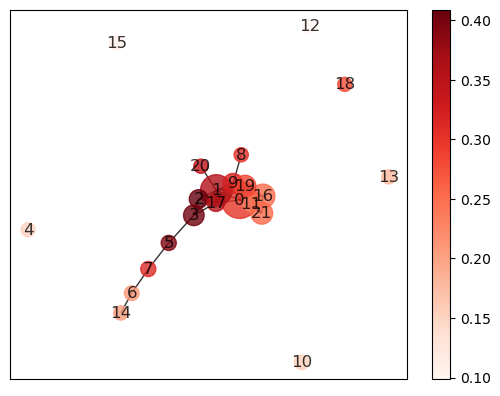

In [862]:
bm1.draw_networkx(coloring_variable='Education Gini Index', colorbar=True)

In [864]:
hsvp = cm.get_cmap("gist_rainbow")

<Axes: >

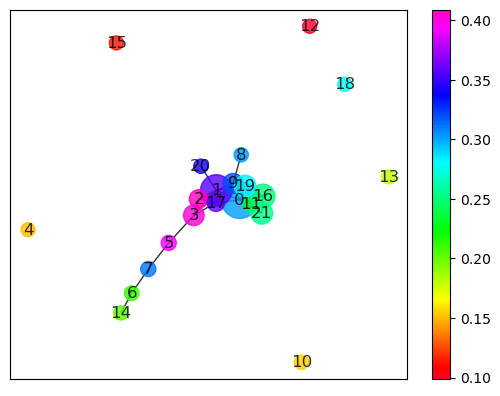

In [866]:
bm1.draw_networkx(coloring_variable='Education Gini Index', color_palette=hsvp, colorbar=True)

In [868]:
pb1 = bm1.points_and_balls()

In [870]:
pb1

,point,ball
0,0,0
1,1,0
2,3,0
3,9,0
4,10,0
...,...,...
738,346,21
739,350,21
740,362,21
741,366,21


In [902]:
data['point'] = data.index

In [904]:
data = data.merge(pb1, on='point')

In [906]:
data_ballmapping = data[['2022 ward', 'LAD Code', 'point', 'ball']]
data_ballmapping.to_csv("data_ballmapping.csv", index=False)

In [908]:
data_ballmapping

,2022 ward,LAD Code,point,ball
0,Astley Bridge,E05000650,0,0
1,Bradshaw,E05000651,1,0
2,Bradshaw,E05000651,1,19
3,Bradshaw,E05000651,2,1
4,Bradshaw,E05000651,3,0
...,...,...,...,...
738,Levenshulme,E05011369,369,9
739,Levenshulme,E05011369,370,16
740,Levenshulme,E05011369,370,21
741,Levenshulme,E05011369,371,0


# Geospatial Analysis

In [911]:
import geopandas as gpd

In [913]:
gb_shape = gpd.read_file('Westminster_Parliamentary_Constituencies__December_2019__Boundaries_UK_BFE.shp')

C:\Users\teppe\anaconda3\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


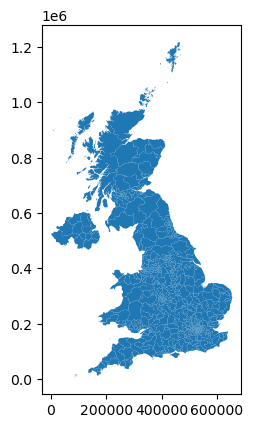

In [914]:
gb_shape.plot(); plt.show()

In [915]:
data_merged

,LAD Code,No qualifications,Level 1 and entry level qualifications,Level 2 qualifications,Apprenticeship,Level 3 qualifications,Level 4 qualifications or above,Total: All usual residents aged 16 years and over,Avg Schooling Years,Education Gini Index,...,Economically active and a full-time student: In employment: Self-employed without employees: Full-time,Economically active and a full-time student: Unemployed,Economically inactive,Economically inactive: Retired,Economically inactive: Student,Economically inactive: Looking after home or family,Economically inactive: Long-term sick or disabled,Economically inactive: Other,point,ball
0,E05000650,0.175,0.103,0.153,0.062,0.179,0.307,100,10.028,0.300037,...,0.0,0.4,40.2,24.5,4.6,4.2,4.3,2.6,0,0
1,E05000651,0.169,0.098,0.127,0.077,0.179,0.325,100,10.211,0.289415,...,0.0,0.8,46.0,33.3,3.5,3.5,3.5,2.2,1,0
2,E05000651,0.169,0.098,0.127,0.077,0.179,0.325,100,10.211,0.289415,...,0.0,0.8,46.0,33.3,3.5,3.5,3.5,2.2,1,19
3,E05000652,0.259,0.118,0.152,0.078,0.163,0.202,100,8.397,0.381300,...,0.0,0.5,44.4,22.6,4.6,5.5,7.7,4.0,2,1
4,E05000653,0.121,0.082,0.134,0.065,0.181,0.398,100,11.251,0.237569,...,0.0,0.4,38.6,28.8,3.7,2.4,2.1,1.6,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,E05000862,0.211,0.107,0.163,0.076,0.178,0.244,100,9.295,0.334952,...,0.1,0.5,37.5,21.0,3.9,4.0,5.7,2.8,369,9
739,E05000863,0.150,0.096,0.153,0.077,0.199,0.303,100,10.369,0.273501,...,0.0,0.5,34.1,24.8,3.1,2.4,2.4,1.3,370,16
740,E05000863,0.150,0.096,0.153,0.077,0.199,0.303,100,10.369,0.273501,...,0.0,0.5,34.1,24.8,3.1,2.4,2.4,1.3,370,21
741,E05000864,0.250,0.115,0.161,0.073,0.168,0.206,100,8.541,0.372512,...,0.0,0.4,41.9,24.9,3.1,4.9,6.1,2.9,371,0


In [919]:
gb_shape = gb_shape.rename(columns={"pcon19cd": "LAD Code"})
data_merged_geo = gb_shape.merge(data_merged, on="LAD Code", how="left")
data_merged_geo = gpd.GeoDataFrame(data_merged_geo, geometry="geometry")
data_merged_geo = data_merged_geo.to_crs("EPSG:4326")
data_merged_geo

,LAD Code,pcon19nm,bng_e,bng_n,long,lat,objectid_1,st_lengths,st_areasha,GlobalID,...,Economically active and a full-time student: In employment: Self-employed without employees: Full-time,Economically active and a full-time student: Unemployed,Economically inactive,Economically inactive: Retired,Economically inactive: Student,Economically inactive: Looking after home or family,Economically inactive: Long-term sick or disabled,Economically inactive: Other,point,ball
0,E14000530,Aldershot,484884,155126,-0.78410,51.288952,1,42197.661729,5.297816e+07,5cd0ebef-55fa-4715-8413-b6029fb4092c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E14000531,Aldridge-Brownhills,404723,302568,-1.93166,52.620869,2,38590.177955,4.401655e+07,ca9e4e30-a733-4f91-b176-147692614cfb,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E14000532,Altrincham and Sale West,374132,389051,-2.39049,53.397659,3,47809.300357,5.093050e+07,74335faa-86c0-4971-847c-3e473b13f4c4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E14000533,Amber Valley,440478,349675,-1.39770,53.042831,4,64666.586610,1.246464e+08,d7c3b021-820e-487a-bad0-ed56cac4c56a,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E14000534,Arundel and South Downs,510686,115542,-0.42635,50.928711,5,231000.827361,6.465128e+08,37b1219f-d5fa-4edd-b159-fbd9b2641337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,W07000076,Caerphilly,316860,188276,-3.20144,51.587181,646,72271.989352,1.145559e+08,fe6dc74c-77c3-4f92-9f3f-701fa891638c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
646,W07000077,Islwyn,320517,196276,-3.15048,51.659618,647,65356.319648,1.119927e+08,70f9393c-52a3-49c5-bbe8-eadd1abf8c4b,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
647,W07000078,Vale of Glamorgan,302293,173081,-3.40742,51.448250,648,98097.079929,3.218606e+08,369d4540-3308-4c34-825e-4d28753f4d76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
648,W07000079,Cardiff West,312437,178939,-3.26294,51.502571,649,40532.801459,5.098017e+07,50073700-b79b-4d83-9e03-c76bbd4b9fb3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [921]:
data_merged_geo["Education Gini Index"]

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
645   NaN
646   NaN
647   NaN
648   NaN
649   NaN
Name: Education Gini Index, Length: 650, dtype: float64

In [516]:
data_merged_geo["Education Gini Index"] = data_merged_geo["Education Gini Index"].fillna(0)
data_merged_geo["Education Gini Index"]

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
645    0.0
646    0.0
647    0.0
648    0.0
649    0.0
Name: Education Gini Index, Length: 650, dtype: float64

C:\Users\teppe\anaconda3\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


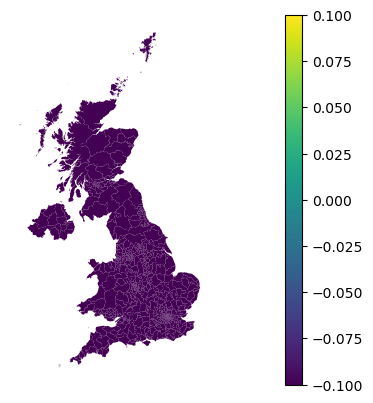

In [508]:
fig, ax = plt.subplots(1,1)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%", pad=0.0)
data_merged_geo.plot(column="Education Gini Index",ax=ax,legend=True,cax=cax)
plt.show()

C:\Users\teppe\anaconda3\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


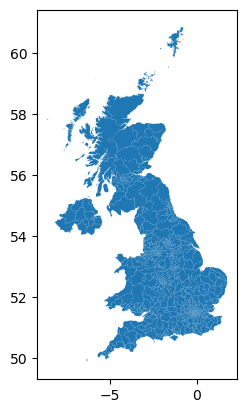

In [510]:
data_merged_geo.plot()
plt.show()

In [512]:
print("Min:", data_merged_geo["Education Gini Index"].min())
print("Max:", data_merged_geo["Education Gini Index"].max())


Min: 0.0
Max: 0.0
